In [1]:
!unzip 'lib.zip'

Archive:  lib.zip
   creating: lib/common/
 extracting: lib/common/__init__.py  
  inflating: lib/common/functions.py  
  inflating: lib/common/gradient.py  
  inflating: lib/common/layers.py    
  inflating: lib/common/multi_layer_net.py  
  inflating: lib/common/multi_layer_net_extend.py  
  inflating: lib/common/optimizer.py  
  inflating: lib/common/trainer.py   
  inflating: lib/common/util.py      
   creating: lib/dataset/
 extracting: lib/dataset/__init__.py  
  inflating: lib/dataset/lena.png    
  inflating: lib/dataset/lena_gray.png  
  inflating: lib/dataset/mnist.py    
  inflating: lib/sample_weight.pkl   


# **6.2重みの初期値**
　ニューラルネットワークの学習で重みはとても重要になってきます。本節では、推奨される重みの初期値について説明し、実験によって重みによる学習の差違を確認します。

## **6.2.1 重みの初期値を0にする？**
　これまで、重みの初期値は`0.01*np.ramdom.randn(10, 100)`のように、ガウス分布から生成される値を0.01倍した小さいな値(0に近い数値)を用いてきました。

　重みは基本的には小さくしたいものです。これは次節以降のWeightDecayにも絡んできて、過学習防止に役立ちます。

　重みを小さくしたいのであれば、重みの初期値を全て0に設定すると良いのではないかということが考えられるが、重みを0に設定するのは良くありません。例えば、Affine層の実装は以下のようになっていました。
```
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b       
        self.x = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx
```
逆伝播の際に、Affine層が持つ重みselt.W(全て0)と行列積をとっていますが、このときに値が全て0になって逆伝播されます。次にそれをdoutとして受け取ったとき、重みの勾配が0になり、重みの更新どころか、重み全てが0のまま何も動かなくる。

## **6.2.2 隠れ層のアクティベーションの分布**
重みの初期値によって、隠れ層のアクティベーション(活性化関数を通した後の数値)がどのように変化するかを観察します。5層のニューラルネットワークに、ランダムに生成した入力データを流し、各層のアクティベーションの分布を可視化します。以下のパターンで確認します。
* 重みの分布
  * 標準偏差1の正規分布
  * 標準偏差0.01の正規分布
  * 標準偏差$\frac{1}{\sqrt{n}}$の正規分布
  * 標準偏差$\sqrt{\frac{2}{n}}$の正規分布
* 活性化関数
  * シグモイド関数
  * tanh関数
  * ReLU関数

### **Xavierの初期値**
* 標準偏差$\frac{1}{\sqrt{n}}$のガウス分布を用いて初期化した重み($n$:前層のノード)
* 各層のアクティベーションを同じ広がりのある分布にすることを目的として、適切な重みのスケールを導いたもの
* 前層のノード数が多いほど対象ノードの初期として設定する重みのスケールは小さくなる
* sigmoidやtanh関数などの左右対称で中央付近が線形関数であることを前提に導いたもの
* [Xavier Gloratらの論文](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

### **Heの初期値(Kaiming He)**
* 標準偏差$\sqrt{\frac{2}{n}}$のガウス分布を用いて初期化した重み($n$:前層のノード)
* Xavierではなく、ReLU関数に特化したものとして推奨


In [2]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ReLU関数
def ReLU(x):
    return np.maximum(0, x)

# tanh関数
def tanh(x):
    return np.tanh(x)

def swish(x):
  return x * sigmoid(x)

# 層のアクティベーション観察用関数
def layer_act(w_std, act_func):
  input_data = np.random.randn(1000, 100)  # 1000個のデータ
  node_num = 100  # 各隠れ層のノード（ニューロン）の数
  hidden_layer_size = 5  # 隠れ層が5層
  activations = {}  # ここにアクティベーションの結果を格納する

  x = input_data

  for i in range(hidden_layer_size):
      if i != 0:
          x = activations[i-1]

      # 初期値の値をいろいろ変えて実験しよう！
      w = np.random.randn(node_num, node_num) * w_std
      # w = np.random.randn(node_num, node_num) * 1
      # w = np.random.randn(node_num, node_num) * 0.01
      # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
      # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

      a = np.dot(x, w)

      # 活性化関数の種類も変えて実験しよう！
      z = act_func(a)
      # z = sigmoid(a)
      # z = ReLU(a)
      # z = tanh(a)

      activations[i] = z

  # ヒストグラムを描画
  for i, a in activations.items():
      plt.subplot(1, len(activations), i+1)
      plt.title(str(i+1) + "-layer")
      plt.tight_layout()
      # if i != 0: plt.yticks([], [])
      # plt.xlim(0.1, 1)
      # plt.ylim(0, 7000)
      low_lim = 0
      if act_func == tanh:
        low_lim = -1
      if act_func == ReLU:
        plt.ylim(0, 7000)
      plt.hist(a.flatten(), 30, range=(low_lim, 1))
  plt.show()

node_num = 100  # 各隠れ層のノード（ニューロン）の数

### sigmoid関数のアクティベーション比較
* 標準偏差1の正規分布
  * 0と1に偏った分布になっている
  * sigmoid関数の性質上0と1に偏った分布では微分の値が0に近づき、勾配の値がどんどん小さくなって消える**勾配消失**が起こる
* 標準偏差0.01の正規分布
  * 0.5付近に集中する分布になっている
  * 0と1への偏りはないので勾配消失の問題は起きない
  * 複数のニューロンが同じ値を出力するとすれば、複数のニューロンが存在する意味がなくなる  
  →1個のニューロンでもほぼ同じことを表現することが出来る
  * この偏りは「表現力」の点で問題
* $\frac{1}{\sqrt{n}}$の正規分布
  * 適度に広がりを持つようになった
  
* $\sqrt{\frac{2}{n}}$の正規分布
  * Xavierの初期値よりも広がりがあるように見える

====標準偏差1====



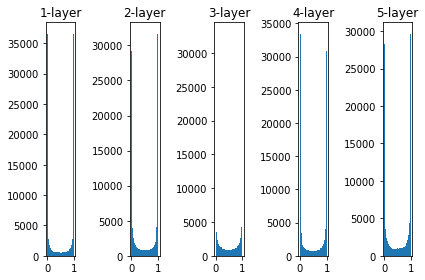

====標準偏差0.01====



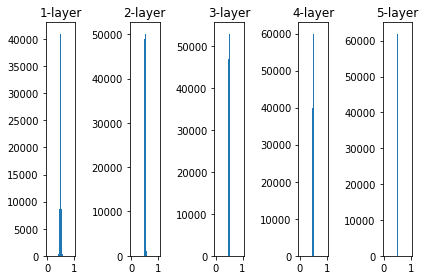

====Xavierの初期値====



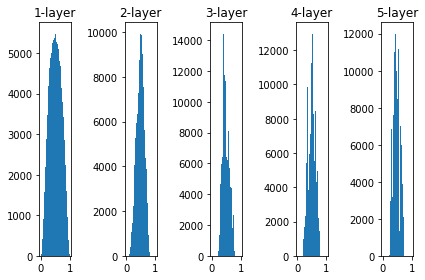

====Heの初期値====



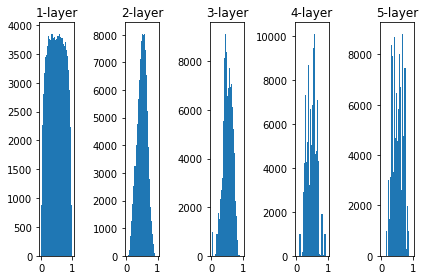

In [ ]:
print("====標準偏差1====\n")
layer_act(1, sigmoid)
print("====標準偏差0.01====\n")
layer_act(0.01, sigmoid)
print("====Xavierの初期値====\n")
layer_act(np.sqrt(1.0 / node_num), sigmoid)
print("====Heの初期値====\n")
layer_act(np.sqrt(2.0 / node_num), sigmoid)

### tanh関数のアクティベーション比較
* 標準偏差1の正規分布
  * sigmoid関数と同様、**勾配消失**が起こる
* 標準偏差0.01の正規分布
  * sigmoidと同様

* $\frac{1}{\sqrt{n}}$の正規分布
  * 最初以外は山型

* $\sqrt{\frac{2}{n}}$の正規分布
  * 層が深くなるにつれ、広がりをもつようになる

====標準偏差1====



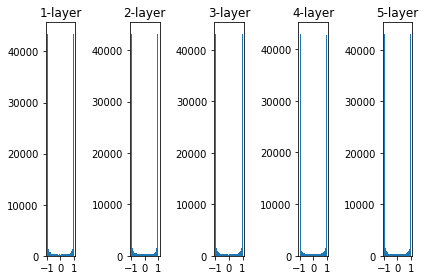

====標準偏差0.01====



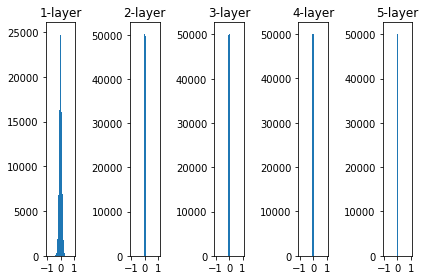

====Xavierの初期値====



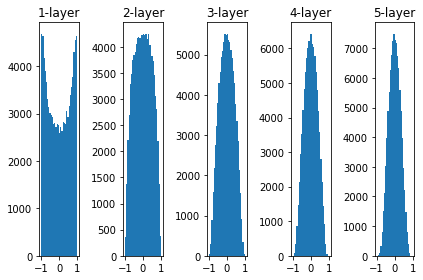

====Heの初期値====



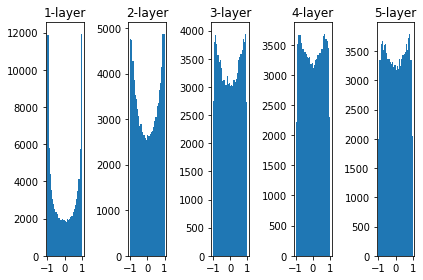

In [ ]:
print("====標準偏差1====\n")
layer_act(1, tanh)
print("====標準偏差0.01====\n")
layer_act(0.01, tanh)
print("====Xavierの初期値====\n")
layer_act(np.sqrt(1.0 / node_num), tanh)
print("====Heの初期値====\n")
layer_act(np.sqrt(2.0 / node_num), tanh)

### ReLU関数のアクティベーション比較
* 標準偏差1の正規分布
  * 0に偏った分布
  * sigmoid関数同様**勾配消失**が起こる
* 標準偏差0.01の正規分布
  * 0に偏った分布
  * 勾配消失
* $\frac{1}{\sqrt{n}}$
  * 層が深くなるにつれ、偏りが大きくなっていく
  * もっと層を深くしていくと、次第に勾配消失の問題を起こすようになる
* $\sqrt{\frac{2}{n}}$
  * 層が深くなっても、一定の広がりを確認できる

====標準偏差1====



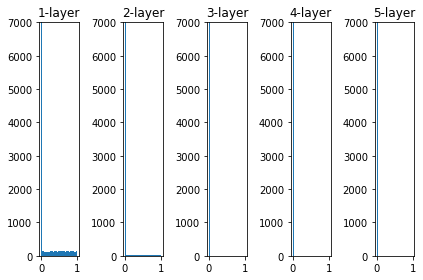

====標準偏差0.01====



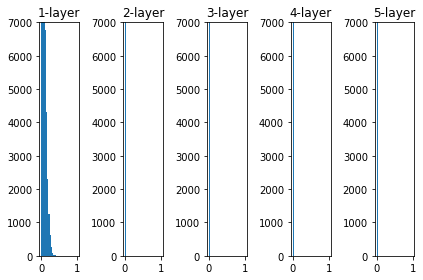

====Xavierの初期値====



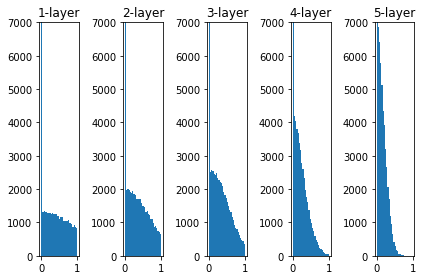

====Heの初期値====



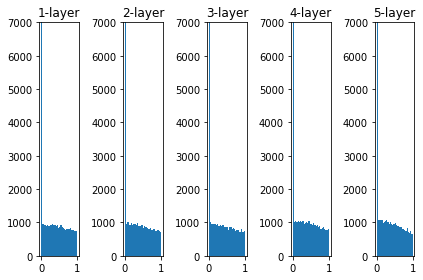

In [ ]:
print("====標準偏差1====\n")
layer_act(1, ReLU)
print("====標準偏差0.01====\n")
layer_act(0.01, ReLU)
print("====Xavierの初期値====\n")
layer_act(np.sqrt(1.0 / node_num), ReLU)
print("====Heの初期値====\n")
layer_act(np.sqrt(2.0 / node_num), ReLU)

　現在は、ReLUを使う場合は、「Heの初期値」、sigmoidやtanhなどのS字カーブのときは「Xavierの初期値」を使うのがベストプラクティクスとなっている


## **6.2.4 MNISTデータセットによる重み初期値の比較**
　実際のデータを対象に、重みの初期値の与え方の違いによって、NNの学習にどれだけ影響を与えるかを見てみます。
* ReLUを使用
* 重みは以下の3つを比較
  * std=0.01
  * Xavierの初期値
  * Heの初期値

で実験を行う

====標準偏差1====



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


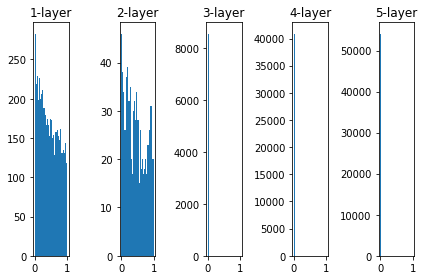

====標準偏差0.01====



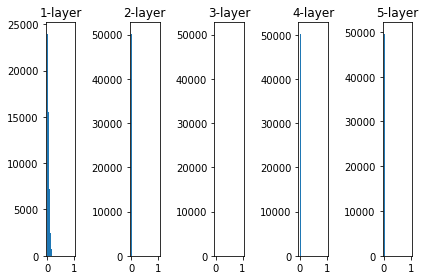

====Xavierの初期値====



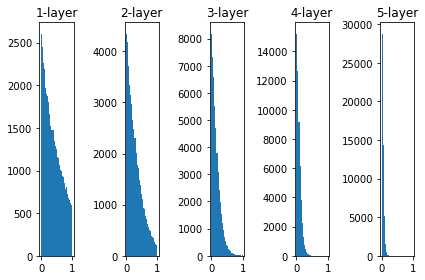

====Heの初期値====



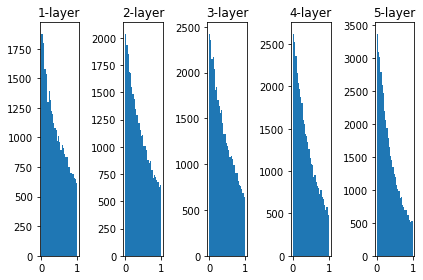

In [4]:
print("====標準偏差1====\n")
layer_act(1, swish)
print("====標準偏差0.01====\n")
layer_act(0.01, swish)
print("====Xavierの初期値====\n")
layer_act(np.sqrt(1.0 / node_num), swish)
print("====Heの初期値====\n")
layer_act(np.sqrt(2.0 / node_num), swish)

====標準偏差1====



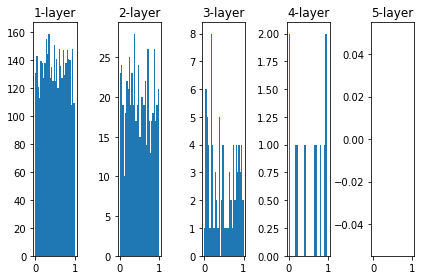

====標準偏差0.01====



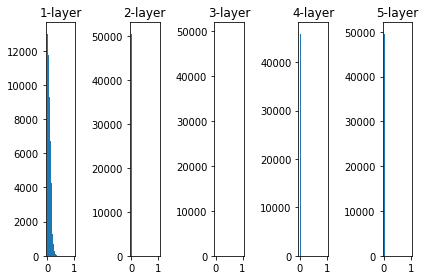

====Xavierの初期値====



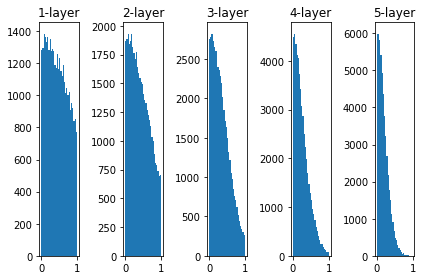

====Heの初期値====



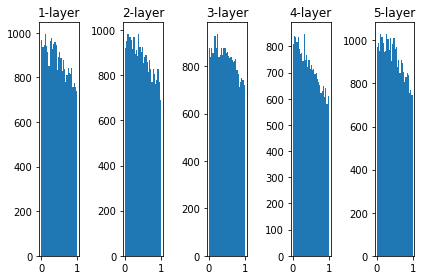

In [5]:
def LRelu(x):
    y = np.where(x > 0, x , 0.01 * x)
    return y

print("====標準偏差1====\n")
layer_act(1, LRelu)
print("====標準偏差0.01====\n")
layer_act(0.01, LRelu)
print("====Xavierの初期値====\n")
layer_act(np.sqrt(1.0 / node_num), LRelu)
print("====Heの初期値====\n")
layer_act(np.sqrt(2.0 / node_num), LRelu)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
===========iteration:0===========
std=0.01:2.302414527034563
Xavier:2.3106935011621044
He:2.3561002876658215
===========iteration:100===========
std=0.01:2.3028673069311267
Xavier:2.2428082258051774
He:1.4539192407091748
===========iteration:200===========
std=0.01:2.303375354593082
Xavier:2.1178717648967
He:0.7853172306251643
===========iteration:300===========
std=0.01:2.3008280432843193
Xavier:1.838205899285671
He:0.5414996971034555
===========iteration:400===========
std=0.01:2.30167025579185
Xavier:1.2372119243360964
He:0.4377560343457
===========iteration:500===========
std=0.01:2.301223421370598
Xavier:0.8770038515126932
He:0.47906826873784214
===========iteration:600===========
std=0.01

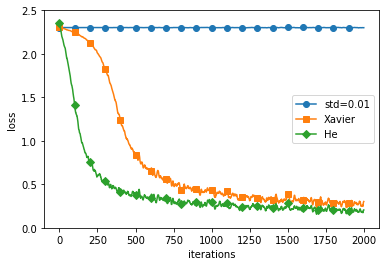

In [ ]:
# coding: utf-8
# import os
# import sys

# sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from lib.dataset.mnist import load_mnist
from lib.common.util import smooth_curve
from lib.common.multi_layer_net import MultiLayerNet
from lib.common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## **Kerasでの実装**
　実用も考えてKerasの重み初期化パラメータによって、損失関数と精度の変化を見てみた。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense # 全結合のレイヤ(層)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f'x_train: {x_train.shape}')  # 訓練データ60000件
print(f'y_train: {y_train.shape}')  # 正解ラベル60000件
print(f'x_test: {x_test.shape}')  # テストデータ10000件
print(f'y_test: {y_test.shape}')  # テストデータ10000件

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [ ]:
# 訓練用関数：X(訓練データ), y(テストデータ), param_init(重みの初期値)
def train(X, y, param_init):
  # NNモデルの定義
  model = Sequential()
  model.add(Dense(units=50, input_shape=(784,), activation='relu',
                  kernel_initializer=param_init,
                  bias_initializer=param_init)) # 中間層
  model.add(Dense(units=10, activation='softmax',
                  kernel_initializer=param_init,
                  bias_initializer=param_init)) # 出力層

  model.compile(
      optimizer='adam',   # 重み(バイアス)更新アルゴリズムとしてAdam
      loss='categorical_crossentropy', # 損失関数に交差エントロピー
      metrics=['accuracy'] # 性能評価の指標に正解率
  )

  # 学習
  hist = model.fit(X, y,
      batch_size=32,
      epochs=8,
      validation_split=0.2) # validationデータに2割使う
    
  print(model.get_config())
  return hist

### **重みの初期値を変えながら、学習を実行**
* Zeros…重みを全て0で初期化
* Ones…重みを全て1で初期化
* Stan_Norm…任意の正規分布
* Glorot_Norm…Xavier Glorotの初期値
* He_Norm…Heの初期値

**※注意**  
+ KerasとPytorchではXavierの正規分布の初期値は以下の標準偏差
$$\sqrt{\frac{2}{n_j(入力ユニット数)+n_{j+1}(出力ユニット数)}}$$
となります。

* Xavierの一様分布というものも存在し、
$$limit=\sqrt{\frac{6}{n_j(入力ユニット数)+n_{j+1}(出力ユニット数)}}$$
のとき、$[-limit, limit]$を範囲とする一様分布で重みが初期化されるようです。  
KerasとPytorchのDense層の初期値はこっち。

* P182の下の注意事項にありますが、$\frac{1}{\sqrt{n}}$で初期化するのは、Caffeというライブラリで、元のXavierの式の単純化が行われているようです。

* [keras document](https://keras.io/ja/initializers/#_1)
* [pytorch document](https://pytorch.org/docs/stable/nn.init.html?highlight=glorot)

In [ ]:
# 28x28の配列を1次元配列に変換後、0~1の間の数字にスケーリング
X = x_train.reshape(60000, 784) /255.

# クラスラベルをone-hot形式に変換
y = to_categorical(y_train, 10)

# 重みの初期値設定
param_init_arr ={"Zeros" : keras.initializers.Zeros(),
                 "Ones" : keras.initializers.Ones(),
                 "Stan_Norm" : keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=0),
                 "Glorot_Norm" : glorot_normal(seed=0),
                 "He_Norm" : he_normal(seed=0)}

# 学習過程保存用dict
hist_arr = {}

# 重みを変えて訓練し、学習過程を保存
for key in param_init_arr:
  hist_arr[key] = train(X, y, param_init_arr[key])

Epoch 1/8
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3014 - accuracy: 0.1134 - val_loss: 2.3022 - val_accuracy: 0.1060
Epoch 2/8
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3012 - accuracy: 0.1140 - val_loss: 2.3024 - val_accuracy: 0.1060
Epoch 3/8
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3011 - accuracy: 0.1140 - val_loss: 2.3021 - val_accuracy: 0.1060
Epoch 4/8
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3012 - accuracy: 0.1140 - val_loss: 2.3021 - val_accuracy: 0.1060
Epoch 5/8
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3011 - accuracy: 0.1140 - val_loss: 2.3022 - val_accuracy: 0.1060
Epoch 6/8
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3011 - accuracy: 0.1140 - val_loss: 2.3022 - val_accuracy: 0.1060
Epoch 7/8
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3011 - accuracy: 0.1140 - val_loss: 2.3022 - val_accuracy: 0.1060

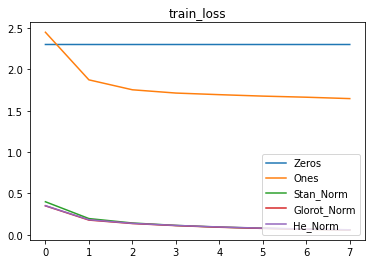

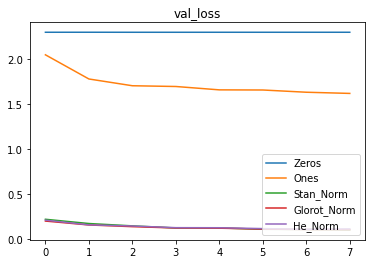

In [ ]:
# 訓練データに対する損失関数
for i in hist_arr:
  plt.plot(hist_arr[i].history['loss'])
  # plt.plot((hist_arr[i].history['val_loss'])

plt.title('train_loss')
plt.legend([i for i in param_init_arr], loc='lower right')
plt.show()

# テストデータに対する損失関数
for i in hist_arr:
  plt.plot(hist_arr[i].history['val_loss'])

plt.title('val_loss')
plt.legend([i for i in param_init_arr], loc='lower right')
plt.show()

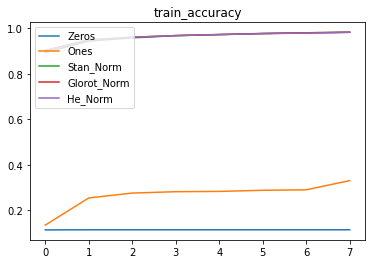

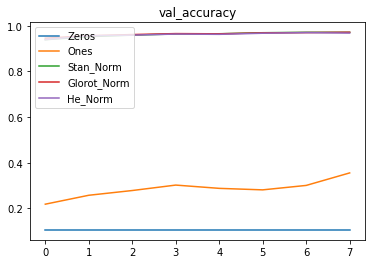

In [ ]:
# 訓練データに対する正解率
for i in hist_arr:
  plt.plot(hist_arr[i].history['accuracy'])
  # plt.plot(hist.history['val_accuracy'])
plt.title('train_accuracy')
plt.legend([i for i in param_init_arr], loc='upper left')
plt.show()

# テストデータに対する正解率
for i in hist_arr:
  plt.plot(hist_arr[i].history['val_accuracy'])
plt.title('val_accuracy')
plt.legend([i for i in param_init_arr], loc='upper left')
plt.show()